# Poses Submission for FEGrow/ A3FE

In [ ]:
import os
import polaris as po
import base64
import pymol
from tqdm import tqdm
from rdkit import Chem
import datamol as dm
from pathlib import Path
import openeye.oechem as oechem

competition = po.load_competition("asap-discovery/antiviral-ligand-poses-2025")
competition.cache()
_, test = competition.get_train_test_split()

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.


INFO:httpx:HTTP Request: POST https://clerk.polarishub.io/oauth/token "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://polarishub.io/api/auth/token "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://polarishub.io/api/v1/competition/asap-discovery/antiviral-ligand-poses-2025 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://polarishub.io/api/auth/token "HTTP/1.1 200 OK"


[2025-03-05 06:36:05] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=994245;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=656691;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.8).                                                                           

INFO:polaris._artifact:The version of Polaris that was used to create the artifact (0.11.0) is different from the currently installed version of Polaris (0.11.8).


                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=786801;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=788480;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

INFO:httpx:HTTP Request: POST https://polarishub.io/api/auth/token "HTTP/1.1 200 OK"


Output()

[06:36:06] Copying to destination                                                                      ]8;id=519152;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=408986;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/dataset/_base.py#380\380]8;;\
           /home/finlayclark/.cache/polaris/datasets/b3a42b84-6521-4824-8700-754e5a3e1058/data.zarr                

           For large Zarr archives, this may take a while.                                             ]8;id=600116;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=129175;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/dataset/_base.py#381\381]8;;\

[06:36:13]  Success: Copying Zarr keys                                                                ]8;id=301208;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=145531;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/utils/context.py#53\53]8;;\

            Success: Copying Zarr archive                                                             ]8;id=811322;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=973397;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/utils/context.py#53\53]8;;\

In [2]:
def get_abfe_runs_dict(abfe_dir: Path) -> dict[int, [int, Path]]:
    """Create a dictionary of {ligand_index: {pose_index: Path}} from the ABFE directory."""
    lig_idxs = set([int(calc_dir.name.split("_")[1]) for calc_dir in abfe_dir.glob("lig_*")])
    lig_runs = {}
    for lig_idx in lig_idxs:
        lig_runs[lig_idx] = {int(calc_dir.name.split("_")[2]): calc_dir for calc_dir in abfe_dir.glob(f"lig_{lig_idx}_*")}
    return lig_runs

# Pure docking
MERS_DOCKED_SDF = Path("../mers-gnina/merged-MERS.sdf")
MERS_ALTERNATE_PROTONATION = Path("../mers-gnina/cs_optimised_reprotonated.sdf")
SARS_DOCKED_SDF = Path("../sars-gnina/merged-SARS.sdf")

# ABFE
MERS_ABFE_DIR = Path("../mers-040225")
# Store the SDFs as a dict of ligand_index: SDF_path
MERS_ABFE_SDFS = {int(lig_sdf.name.split("_")[-1].split(".")[0]): lig_sdf for lig_sdf in (MERS_ABFE_DIR / "input" / "full_run-MERS" / "structures").glob("*.sdf")}
MERS_ABFE_RUNS = get_abfe_runs_dict(MERS_ABFE_DIR)

SARS_ABFE_DIR = Path("../sars-290125-plato")
SARS_ABFE_SDFS = {int(lig_sdf.name.split("_")[-1].split(".")[0]): lig_sdf for lig_sdf in (SARS_ABFE_DIR / "input" / "full_run-SARS" / "structures").glob("*.sdf")}
SARS_ABFE_RUNS = get_abfe_runs_dict(SARS_ABFE_DIR)

SARS_ABFE_EXTRA_POSES_DIR = Path("../sars-extra-poses-210225")
SARS_ABFE_EXTRA_POSES_SDFS = {int(lig_sdf.name.split("_")[-1].split(".")[0]): lig_sdf for lig_sdf in (SARS_ABFE_EXTRA_POSES_DIR / "input" / "structures-SARS-comp48").glob("*.sdf")}
SARS_ABFE_EXTRA_POSES_RUNS = get_abfe_runs_dict(SARS_ABFE_EXTRA_POSES_DIR)

# Reference structures
MERS_REF = Path("../ref_structures/mers_ref.pdb")
SARS_REF = Path("../ref_structures/sars_ref.pdb")

# Containers for results
y_pred_mers = []
y_pred_sars = []

## Extract Docked Structures

These are just the best-scoring (with GNINA) structures from docking (for problematic poses for which ABFE was not run).

In [3]:
def read_sdf(sdf:Path)-> list[Chem.Mol]:
    with Chem.SDMolSupplier(sdf.as_posix()) as suppl:
        mols = [mol for mol in suppl if mol]
        # Check that no molecules are None
        assert all(mols)
    return mols

y_pred_mers.extend(read_sdf(MERS_DOCKED_SDF))
y_pred_mers.extend(read_sdf(MERS_ALTERNATE_PROTONATION))
y_pred_sars.extend(read_sdf(SARS_DOCKED_SDF))

## Select the Poses Scored Best with Fast ABFE

(Run using A3FE)

In [ ]:
# Functions to extract the equilibrated poses from the ABFE runs
# This is very convoluted and there has to be a better way...
# Let me know if you know a better method.

def swap_coordinates_if_order_matches(
    coords_sdf_path: Path, connectivity_sdf_path: Path, output_sdf_path: Path
) -> None:
    """
    Check if two SDFs have the same atom order. If they do, swap coordinates from the
    coords_sdf to the connectivity_sdf and save the result.
    """
    # Load the SDF molecules
    coords_supplier = Chem.SDMolSupplier(str(coords_sdf_path))
    connectivity_supplier = Chem.SDMolSupplier(str(connectivity_sdf_path))
    
    coords_mol = coords_supplier[0]
    connectivity_mol = connectivity_supplier[0]

    if coords_mol is None or connectivity_mol is None:
        raise ValueError("Molecules are None.")

    # Check if the number of atoms is the same
    if coords_mol.GetNumAtoms() != connectivity_mol.GetNumAtoms():
        raise ValueError("Number of atoms do not match.")
    
    # Check if the atom types match for both molecules
    for atom1, atom2 in zip(coords_mol.GetAtoms(), connectivity_mol.GetAtoms()):
        if atom1.GetSymbol() != atom2.GetSymbol():
            raise ValueError("Atom types do not match.")

    # Extract the conformers (coordinates)
    coords_conformer = coords_mol.GetConformer(0)
    connectivity_conformer = connectivity_mol.GetConformer(0)
    
    if coords_conformer is None or connectivity_conformer is None:
        raise ValueError("Conformers are None.")

    # Swap the coordinates from coords_mol to connectivity_mol
    for i in range(coords_mol.GetNumAtoms()):
        pos = coords_conformer.GetAtomPosition(i)
        connectivity_conformer.SetAtomPosition(i, pos)

    # Save the new SDF with swapped coordinates
    writer = Chem.SDWriter(str(output_sdf_path))
    writer.write(connectivity_mol)
    writer.close()


def align_pred(abfe_dir: Path, ref_path:Path) -> Path:

    # Write the protein pdb
    input_dir = abfe_dir / "input"
    aligned_pdb_path = input_dir / "bound_preequil_aligned.pdb"
    parm7_path = input_dir / "bound_preequil.parm7"
    rst7_path = input_dir / "bound_preequil.rst7"
    aligned_oe_sdf_path = input_dir / "ligand_aligned_oe.sdf"
    aligned_sdf_path = input_dir / "ligand_aligned_final.sdf"

    # Create a soft link to "bound_preequil.prm7" as "bound_preequil.parm7" so that pymol can read it.
    if not (abfe_dir / "input" / "bound_preequil.parm7").exists():
        os.symlink((abfe_dir / "input" / "bound_preequil.prm7").absolute(), (abfe_dir / "input" / "bound_preequil.parm7").absolute())

    # Align the protein to the reference
    pymol.cmd.delete("all")

    # Aligning by binding site residues only didn't change things much
    binding_site_res_8 = ['46', '126', '173', '47', '54', '186', '144', '21', '39', '175', '20', '189', '190', '44', '166', '118', '138', '192', '25', '165', '42', '24', '163', '41', '185', '139', '181', '27', '49', '50', '1', '141', '22', '145', '187', '170', '146', '52', '140', '45', '161', '167', '2', '164', '26', '40', '28', '23', '48', '85', '142', '43', '171', '188', '174', '143', '147', '172']
    binding_site_res_5 = ['46', '54', '144', '189', '44', '166', '25', '165', '42', '163', '24', '41', '181', '27', '49', '1', '141', '145', '187', '140', '164', '26', '142', '188', '143', '172']

    # Load into pymol - from amber files
    pymol.cmd.load(parm7_path, "mobile")
    pymol.cmd.load(rst7_path, "mobile")
    pymol.cmd.load(ref_path, "reference")
    pymol.cmd.align(
        "polymer and mobile",
        "chain A and reference",
        # "resi " + "+".join(binding_site_res_8) + " and mobile",
        # "resi " + "+".join(binding_site_res_8) + " and reference",
    )

    session_path = input_dir / "bound_preequil_aligned.pse"
    pymol.cmd.save(session_path)
    pymol.cmd.save(aligned_pdb_path, "mobile and resname LIG")

    # Process the aligned pdb to get the sdf with openeye
    ifs = oechem.oemolistream(aligned_pdb_path.as_posix())
    mol = oechem.OEMol()
    oechem.OEReadMolecule(ifs, mol)
    ifs.close()

    # Add aromaticity/ stereochemistry etc
    oechem.OEClearAromaticFlags(mol)
    oechem.OEAssignAromaticFlags(mol, oechem.OEAroModel_MDL)
    oechem.OEAssignHybridization(mol)
    oechem.OEAddExplicitHydrogens(mol)

    ofs = oechem.oemolostream(aligned_oe_sdf_path.as_posix())
    oechem.OEWriteMolecule(ofs, mol)
    ofs.close()

    # The openeye sdf still doesn't have all the information we need, so
    # swap the coordinates from the aligned OE sdf to the original sdf,
    # which are in the correct order.
    swap_coordinates_if_order_matches(aligned_oe_sdf_path, abfe_dir / "input" / "ligand.sdf", aligned_sdf_path)

    # Read in the final aligned SDF and add back hydrogens with OE
    ifs = oechem.oemolistream(aligned_sdf_path.as_posix())
    mol = oechem.OEMol()
    oechem.OEReadMolecule(ifs, mol)
    oechem.OEAddExplicitHydrogens(mol)
    ofs = oechem.oemolostream(aligned_sdf_path.as_posix())
    oechem.OEWriteMolecule(ofs, mol)
    ofs.close()

    return aligned_sdf_path

def get_equil_rdmol(abfe_dir:Path, ref_path:Path) -> Chem.Mol:

    aligned_sdf_path = align_pred(abfe_dir, ref_path)
    aligned_rdmol = Chem.SDMolSupplier(aligned_sdf_path.as_posix())[0]
    assert aligned_rdmol, f"Failed to read molecule from {aligned_sdf_path}"

    return aligned_rdmol

In [5]:
# Sanity check
aligned_mol = get_equil_rdmol(SARS_ABFE_RUNS[51][3], SARS_REF)
orig_mol = read_sdf(SARS_ABFE_SDFS[51])[3]
# Check that they are the same molecule
assert Chem.MolToSmiles(aligned_mol) == Chem.MolToSmiles(orig_mol)
Chem.rdMolAlign.CalcRMS(aligned_mol, orig_mol)

 ObjectMolecule: read coordinates into state 1...


1.9809105882448834

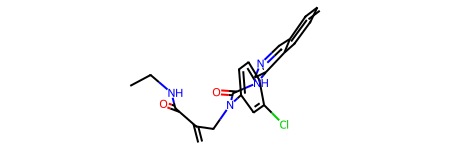

In [39]:
aligned_mol

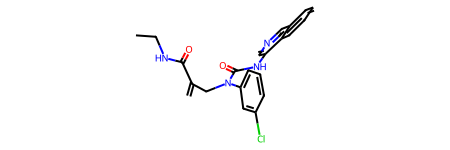

In [33]:
orig_mol

In [6]:
def read_abfe_score(abfe_dir: Path) -> float:
    lines = (abfe_dir / "output" / "overall_stats.dat").read_text().split("\n")
    return float(lines[1].split("Mean free energy: ")[1].split(" ")[0])

def extract_best_scored_conformers(sdfs: dict[int, Path], runs: dict[int, dict[int, Path]], align_ref:Path) -> tuple[list[Chem.Mol], list[float]]:
    """Get the best scored conformer for each ligand from the ABFE runs."""

    mols = []
    # Store the rmsds between the original and equilibrated conformers, when equilibration has been performed
    rmsds = []

    for mol_idx, sdf in sdfs.items():
        conformers = read_sdf(sdf)

        # If there is no ABFE run for this ligand, just take the first conformer
        if mol_idx not in runs.keys():
            mols.append(conformers[0])
            continue

        # Get the best scored pose index
        conformer_scores = {pose_idx: read_abfe_score(abfe_dir) for pose_idx, abfe_dir in runs[mol_idx].items()}
        best_pose_idx = min(conformer_scores.keys(), key=lambda x: conformer_scores[x])

        # Get the rmsd between the equilibrated and original conformers
        best_input_conformer = conformers[best_pose_idx]
        best_equil_conformer = get_equil_rdmol(runs[mol_idx][best_pose_idx], align_ref)
        rmsd = Chem.rdMolAlign.CalcRMS(best_input_conformer, best_equil_conformer)
        if rmsd > 3:
            print(f"High RMSD of {rmsd} for {runs[mol_idx][best_pose_idx]}")
        rmsds.append(rmsd)

        mols.append(best_equil_conformer)

    return mols, rmsds

best_confs_mers, rmsds_mers = extract_best_scored_conformers(MERS_ABFE_SDFS, MERS_ABFE_RUNS, MERS_REF)
best_confs_sars, rmsds_sars = extract_best_scored_conformers(SARS_ABFE_SDFS, SARS_ABFE_RUNS, SARS_REF)
best_confs_sars_extra, rmsds_sars_extra = extract_best_scored_conformers(SARS_ABFE_EXTRA_POSES_SDFS, SARS_ABFE_EXTRA_POSES_RUNS, SARS_REF)

y_pred_mers.extend(best_confs_mers)
y_pred_sars.extend(best_confs_sars)
y_pred_sars.extend(best_confs_sars_extra)

 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
High RMSD of 3.0924029122073615 for ../mers-040225/lig_9_1
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...


 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...


 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
High RMSD of 3.3962636024229416 for ../sars-290125-plato/lig_4_1
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates i

 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
High RMSD of 3.3895956662244844 for ../sars-290125-plato/lig_25_2
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates 

High RMSD of 3.3972752273827083 for ../sars-290125-plato/lig_64_0
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
High RMSD of 3.311928652613157 for ../sars-290125-plato/lig_67_2
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...
 ObjectMolecule: read coordinates into state 1...


Text(0, 0.5, 'Frequency')

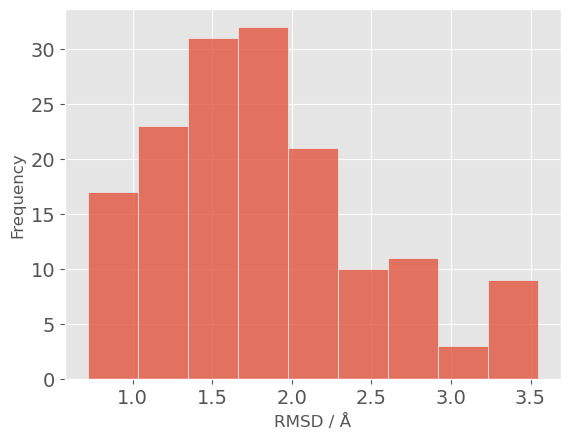

In [7]:
# Check out distribution of RMSDs
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
fig, ax = plt.subplots()
rmsds_all = rmsds_sars + rmsds_sars_extra + rmsds_mers
sns.histplot(rmsds_all, ax=ax)
ax.set_xlabel("RMSD / Å")
ax.set_ylabel("Frequency")

## Format Submission

Merge the conformers into a list with the expected order.

In [9]:
y_pred_merged = []
protein_label_to_pred = {"MERS-CoV Mpro": y_pred_mers, "SARS-CoV-2 Mpro": y_pred_sars}

def remove_double_bond_stereo(smiles:str) -> str:
    mol = Chem.MolFromSmiles(smiles)
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.DOUBLE:
            bond.SetStereo(Chem.BondStereo.STEREONONE)  # Remove E/Z info
    return Chem.CanonSmiles(Chem.MolToSmiles(mol, isomericSmiles=True))  # Keep chirality

for test_idx in tqdm(range(len(test))):
    found_match = False
    test_smiles = test[test_idx]["CXSMILES"]
    protein_label = test[test_idx]["Protein Label"]

    for pred_sdf in protein_label_to_pred[protein_label]:
        pred_smiles = Chem.CanonSmiles(Chem.MolToSmiles(pred_sdf))
        if test_smiles == pred_smiles:
            y_pred_merged.append(pred_sdf)
            found_match = True
            break

    # If we haven't found a match yet, try removing double bond stereochmistry
    if not found_match:
        for pred_sdf in protein_label_to_pred[protein_label]:
            pred_smiles = Chem.CanonSmiles(Chem.MolToSmiles(pred_sdf))
            pred_smiles = remove_double_bond_stereo(pred_smiles)
            if test_smiles == pred_smiles:
                y_pred_merged.append(pred_sdf)
                found_match = True
                break

    if not found_match:
        raise RuntimeError(f"No matching prediction found for test index {test_idx, protein_label, test_smiles}")

100%|██████████| 195/195 [00:04<00:00, 44.86it/s]


Sanity checking...

In [13]:
def check_same_ligands(ref_mol: Chem.Mol, pred_mol: Chem.Mol) -> None:
    # Check that we only have one conformer
    assert ref_mol.GetNumConformers() == 1
    assert pred_mol.GetNumConformers() == 1

    # Check that the SMILES are the same
    ref_smiles = Chem.CanonSmiles(Chem.MolToSmiles(ref_mol))
    pred_smiles = Chem.CanonSmiles(Chem.MolToSmiles(pred_mol))
    assert ref_smiles == pred_smiles, "Smiles are not the same"


In [14]:
# Check that the coordinates of the first MERS ligand match the input for the best-scoring ABFE conformer
# The pose with idx 4 had the best ABFE score for ligand 0
ref_mol = read_sdf(MERS_ABFE_RUNS[0][4] / "input" / "ligand.sdf")[0]
pred_mol = y_pred_merged[0]
check_same_ligands(ref_mol, pred_mol)

# Check that the coordinates of the last MERS ligand match the input for the best-scoring ABFE conformer
# The pose with idx 3 had the best ABFE score for this ligand
ref_mol = read_sdf(MERS_ABFE_RUNS[96][3] / "input" / "ligand.sdf")[0]
pred_mol = y_pred_merged[-3]
check_same_ligands(ref_mol, pred_mol)

# Test one SARS ligand
ref_mol = read_sdf(SARS_ABFE_RUNS[1][0] / "input" / "ligand.sdf")[0]
pred_mol = y_pred_merged[5]
check_same_ligands(ref_mol, pred_mol)

In [9]:
# Write out one structure to sdf to visualise
with Chem.SDWriter("test.sdf") as writer:
    writer.write(y_pred_merged[-3])

In [15]:
def serialize_rdkit_mol(mol: Chem.Mol) -> str:
    props = Chem.PropertyPickleOptions.AllProps
    mol_bytes = mol.ToBinary(props)
    return base64.b64encode(mol_bytes).decode('ascii')  


y_pred_serialized = [serialize_rdkit_mol(mol) for mol in y_pred_merged]

## Submit

In [16]:
competition.submit_predictions(
    predictions=y_pred_serialized,
    prediction_name="newcastle-edinburgh-fegrow-a3fe-equilibrated-no-training",
    prediction_owner="fjclark",
    report_url="https://github.com/michellab/polaris-poses-challenge-fegrow-a3fe", 
    github_url="https://github.com/michellab/polaris-poses-challenge-fegrow-a3fe",
    description="FEgrow/A3FE submission by Finlay Clark, Asma Feriel Khoualdi, Josh Horton, Julien Michel and Daniel Cole (v2). No training data were used.",
    tags=["FEgrow", "ANI", "OpenMM", "ABFE", "A3FE", "MD"],
    user_attributes={"Framework": "FEgrow/A3FE", "Method": "Constrained geometry optimisation with ML/MM (without use of training set), followed by 0.2 ns of MD equilibration and scoring with fast ABFE calculations."}
)

INFO:httpx:HTTP Request: POST https://polarishub.io/api/v1/competition-prediction "HTTP/1.1 201 Created"


[07:15:23]  Success: Submitting competition predictions                                               ]8;id=341886;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=71579;file:///home/finlayclark/anaconda3/envs/mamba/envs/polaris-challenge-a3fe/lib/python3.11/site-packages/polaris/utils/context.py#53\53]8;;\